# import lib

In [3]:
import os,sys
import random
import tensorflow as tf
import numpy as np
import itertools

import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from tensorflow import keras
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score,confusion_matrix

from sklearn.utils import shuffle

### path 

In [4]:
pre_dataset_rootdir = '/home/ubuntu/Dataset/preprocessing3/'
subject_tot_num = 194

In [14]:
# search all of .npy files 
def search_file(root_dir,e_num,using=[0,1,2]):
    '''
    Need a label file
    
    '''
    subject_file_dict=dict()
    
    label_filename = './현황_간소화.xlsx'

    label_df = pd.read_excel(label_filename,header=2).drop([0]) # remove first line(figure)
    label_df = label_df[['실험NO.','중증도\n5단계']]
    label_df.columns=['subjectnb','label']
    label_df.replace({'label':{'Normal':0,'Presymptomatic AD':0,'Prodroaml AD':1,'AD Dementia 초기 ':3,'AD Dementia 초기':3,'AD Dementia 중기 ':4,'AD Dementia중기 ':4,'MCI unlikely due to AD':5,'PET or CSF (x)':6}},inplace=True)
    label_df.set_index(['subjectnb'],inplace=True)
    
    using_snum=[]
    
    for subject_num in range(1,subject_tot_num+1):
        subject_file_dict['S{:03}'.format(subject_num)]=dict()
        subject_file_dict['S{:03}'.format(subject_num)]['file_list']=[]
        subject_file_dict['S{:03}'.format(subject_num)]['severity'] = label_df.loc['S{:03}'.format(subject_num)]['label']
        if subject_file_dict['S{:03}'.format(subject_num)]['severity'] in using:
            using_snum.append(subject_num)
            
    for (path, dir, files) in os.walk(root_dir):
        for file in files:
            if '.npy' in file and 'E{}'.format(e_num) in path:
                subject_num = path.split('/')[-2]
            
                label = label_df.loc[subject_num]['label']
                if label not in using:
                    continue
                subject_file_dict[subject_num]['file_list'].append(path +'/'+ file)
    
    return subject_file_dict,using_snum

In [15]:
s_dict,u_snum = search_file(pre_dataset_rootdir,e_num=4,using=[0,1,2])

In [16]:
s_dict

{'S001': {'file_list': ['/home/ubuntu/Dataset/preprocessing3/S001/E4/3_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S001/E4/3_T2.npy',
   '/home/ubuntu/Dataset/preprocessing3/S001/E4/0_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S001/E4/4_T2.npy',
   '/home/ubuntu/Dataset/preprocessing3/S001/E4/4_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S001/E4/2_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S001/E4/2_T2.npy'],
  'severity': 0},
 'S002': {'file_list': [], 'severity': 0},
 'S003': {'file_list': [], 'severity': 0},
 'S004': {'file_list': [], 'severity': 0},
 'S005': {'file_list': ['/home/ubuntu/Dataset/preprocessing3/S005/E4/3_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S005/E4/10_T2.npy',
   '/home/ubuntu/Dataset/preprocessing3/S005/E4/10_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S005/E4/1_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S005/E4/0_T2.npy',
   '/home/ubuntu/Dataset/preprocessing3/S005/E4/7_T1.npy',
   '/home/ubuntu/Dataset/preprocessing3/S

In [22]:
# load .npy file and minmax scaler
def load_data(filename):
    data = np.load(filename)
#     for i,ts in enumerate(data):
#         data[i] = signal.resample(ts,256)
    data = np.reshape(data,(63,-1),order='C')
    data = np.transpose(data,(1,0))
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(data)
    
    return data

for i in range(1,194):
    if s_dict['S{:03}'.format(i)]['severity']==3:
        print(s_dict['S{:03}'.format(i)])
tmp_filename='/home/ubuntu/Dataset/preprocessing4/S001/E3/0_T1.npy'
tmp_data = load_data(tmp_filename)
print(np.shape(tmp_data))

In [23]:
tmp_filename='/home/ubuntu/Dataset/preprocessing3/S001/E4/0_T1.npy'
tmp_data = load_data(tmp_filename)
print(np.shape(tmp_data[:,0]))

(3639,)


In [25]:
# window slicing, 
def preprocessing(data,label):
    
    
    res_x,res_y = [],[]
    interval = 1000
    stride = 500
    
    stind = 0
    
    while stind+interval < len(data) :
        
        tmp_data = data[stind:stind+interval]        
        res_x.append(tmp_data)
        res_y.append(label)
        stind+=stride
        
    return res_x,res_y

def plot_data(data):
    location = ['Waist','LegL','LegR','ThighL','ThighR','ToeL','ToeR']
    sensors=['accel','gyro','mag']
    axis=['x','y','z']
    plt.figure(figsize=(20,25))
    for i in range(63):
        plt.subplot(7,9,i+1)
        plt.title(location[i//9]+'_'+sensors[(i%7)//3]+'_'+axis[i%7%3])
        plt.plot(data[:,i])
    pass

plot_data(tmp_data)

In [26]:
# train:val:test split
def train_val_test_split(subject_dict,using_snum=None,subject_tot_num=subject_tot_num,seed=7):
    if using_snum is None:
        tot_sbnum = list(range(1,subject_tot_num+1))
    else:
        tot_sbnum=using_snum
        
    train_list,remain_list = train_test_split(tot_sbnum,test_size=0.3, random_state=seed)#random.randint(1,1000))
    val_list,test_list = train_test_split(remain_list,test_size=0.7, random_state=seed)#random.randint(1,1000))
    X_train,X_val,X_test,y_train,y_val,y_test = [],[],[],[],[],[]
    train_list.sort(),val_list.sort(),test_list.sort()
    print(train_list,val_list,test_list)


    for subject_num in subject_dict:
        if int(subject_num[1:]) not in using_snum:
            continue
        if int(subject_num[1:]) in train_list:
            for file in subject_dict[subject_num]['file_list']:
                data = load_data(file)
                label = subject_dict[subject_num]['severity']
                tx,ty = preprocessing(data,label)
                X_train.extend(tx)
                y_train.extend(ty)
        elif int(subject_num[1:]) in val_list:
            for file in subject_dict[subject_num]['file_list']:
                data = load_data(file)
                label = subject_dict[subject_num]['severity']
                tx,ty = preprocessing(data,label)
                X_val.extend(tx)
                y_val.extend(ty)
        elif int(subject_num[1:]) in test_list:
            for file in subject_dict[subject_num]['file_list']:
                data = load_data(file)
                label = subject_dict[subject_num]['severity']
                tx,ty = preprocessing(data,label)
                X_test.extend(tx)
                y_test.extend(ty)
        else:
            print(subject_num,'why?')
    print(np.shape(X_train),np.shape(X_val),np.shape(X_test))

    return X_train,X_val,X_test,y_train,y_val,y_test

In [27]:
def augment():
    pass

In [37]:
# create tf dataset
def create_dataset(X_list,y_list,aug=False, shuffle=True, batch_size=16,mode='train'):
    data_list,label_list = X_list,y_list
    
#     label_list = np.reshape(label_list,(-1,1))
#     enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
#     label_list = enc.fit_transform(label_list)
    
    ds = tf.data.Dataset.from_tensor_slices((np.array(data_list), np.array(label_list).astype(np.uint8)))
    ds = ds.batch(batch_size)
    

    if mode=='train':
        ds = ds.shuffle(buffer_size=len(X_list), reshuffle_each_iteration=True) 
        ds = ds.repeat(2) 
        return ds.prefetch(1)
    if mode=='val':
        ds = ds.shuffle(buffer_size=len(X_list), reshuffle_each_iteration=True) 
        ds = ds.repeat(2) 
        return ds.prefetch(1)
    if mode=='test':
        
        return ds.prefetch(1),data_list,label_list

### deep model

In [94]:
# deep model
def identity_block(input_tensor,filters):
    f1,f2,f3 = filters
    x = Conv2D(f1,1,kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2,3,kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3,1,kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Add()([x,input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor,filters):
    f1,f2,f3 = filters

    x = Conv2D(f1,1,kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f2,3,kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f3,1,kernel_initializer='he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    shortcut = Conv2D(f3,1,kernel_initializer='he_normal')(input_tensor)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x,shortcut])
    x = Activation('relu')(x)
    
    return x



def get_model3(input_shape,nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)
    
    x = ZeroPadding1D(padding=3)(input_layer)
    x = Conv1D(100, 7)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
#     x = ZeroPadding1D(padding=1)(x)
    x = MaxPooling1D(2,strides=2)(x)
    
    
    x = tf.expand_dims(x,axis=-1)
    
    
    
    
    x = conv_block(x,[32,32,64])
    x = identity_block(x,[32,32,64])
#     x = identity_block(x,[32,32,64])
    
    x = conv_block(x,[64,64,128])
#     x = identity_block(x,[64,64,128])
    x = identity_block(x,[64,64,128])

    x = GlobalAveragePooling2D()(x)
    
    
    
    
    # FINAL

    output_layer = keras.layers.Dense(nb_classes)(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

    file_path =  '/home/ubuntu/Dataset/weight/best_model.hdf5'

    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                       save_best_only=True)
    
    callbacks = [reduce_lr, model_checkpoint]

    return model



def get_model2(input_shape,nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)
    
    x = Bidirectional(LSTM(50,return_sequences=True,),merge_mode='sum')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)

    x = Bidirectional(LSTM(50))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # FINAL

    output_layer = keras.layers.Dense(nb_classes,activation='relu')(x)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

    file_path =  '/home/ubuntu/Dataset/weight/best_model.hdf5'

    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                       save_best_only=True)
    
    callbacks = [reduce_lr, model_checkpoint]

    return model
def get_model(input_shape, nb_classes):
    n_feature_maps = 64

    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

    file_path =  '/home/ubuntu/Dataset/weight/best_model.hdf5'

    model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
                                                       save_best_only=True)
    
    callbacks = [reduce_lr, model_checkpoint]

    return model


### test result figure 

In [95]:
# test result visulization
def test(model,history,test_ds,y_test):
    plt.figure(figsize=(10,30))
    plt.subplot(311)
    plt.title('loss')
    plt.plot(history.history['loss'],'-b')
    plt.plot(history.history['val_loss'],'-r')
    plt.legend(['train','val'])

    plt.subplot(312)
    plt.title('accuracy')
    plt.plot(history.history['accuracy'],'-b')
    plt.plot(history.history['val_accuracy'],'-r')
    plt.legend(['train','val'])

    plt.subplot(313)
    y_pred = np.argmax(model.predict(test_ds),axis=-1)
    y_true = np.argmax(y_test,axis=-1)
    cnf_matrix = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cnf_matrix,['N','MCI'],title='model : Deep learning')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    
    

In [96]:
def onehot(y):
    y = np.reshape(y,(-1,1))
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    y = enc.fit_transform(y)
    
    return y

In [99]:
# execute model train,test
def trying():
    
    epochs=30
    batch_size= 16
    model = get_model2(input_shape = (1000,63),nb_classes = 2)
    
    s_dict,u_snum = search_file(pre_dataset_rootdir,e_num=4,using=[0,1,2])
    X_train,X_val,X_test,y_train,y_val,y_test = train_val_test_split(s_dict,using_snum=u_snum)
    
    
#     print(y_train[:10])
    y_train,y_val,y_test = onehot(y_train),onehot(y_val),onehot(y_test)
#     print(y_train[:10])
#     print(np.shape(X_train),np.shape(y_train))
    
    X_train,y_train = shuffle(X_train,y_train)
    X_val,y_val = shuffle(X_val,y_val)
#     print(y_train[:10])

    
    train_dataset = create_dataset(X_train,y_train,batch_size=batch_size,mode='train')
    val_dataset = create_dataset(X_val,y_val,batch_size=batch_size,mode='val')
    test_dataset,data_list,label_list = create_dataset(X_test,y_test,batch_size=batch_size,mode='test')
    
#     early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss') 
    
    history = model.fit(train_dataset,validation_data=val_dataset,epochs=epochs,callbacks=[])
#     Model.fit
    test(model,history,test_dataset,label_list)

[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 17, 19, 21, 23, 24, 26, 27, 28, 29, 30, 32, 34, 36, 38, 39, 40, 42, 43, 45, 46, 48, 49, 51, 53, 54, 55, 58, 59, 61, 62, 63, 64, 65, 68, 69, 70, 72, 73, 76, 79, 82, 83, 84, 86, 87, 88, 89, 90, 91, 96, 97, 98, 101, 102, 103, 104, 105, 108, 109, 110, 111, 113, 114, 117, 118, 120, 122, 125, 126, 127, 129, 130, 131, 132, 134, 135, 138, 141, 145, 147, 148, 149, 151, 152, 153, 154, 155, 160, 161, 162, 163, 164, 167, 171, 172, 173, 174, 175, 177, 178, 183, 184, 187, 191] [18, 35, 41, 77, 81, 94, 100, 119, 124, 140, 150, 159, 165, 168, 190] [20, 31, 33, 37, 47, 50, 56, 57, 60, 75, 78, 80, 85, 92, 93, 95, 99, 112, 115, 116, 121, 123, 128, 133, 136, 137, 139, 143, 144, 146, 157, 158, 170, 176, 192]
(1764, 1000, 63) (265, 1000, 63) (467, 1000, 63)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
(1764, 1000, 63) (1764, 2)
[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]


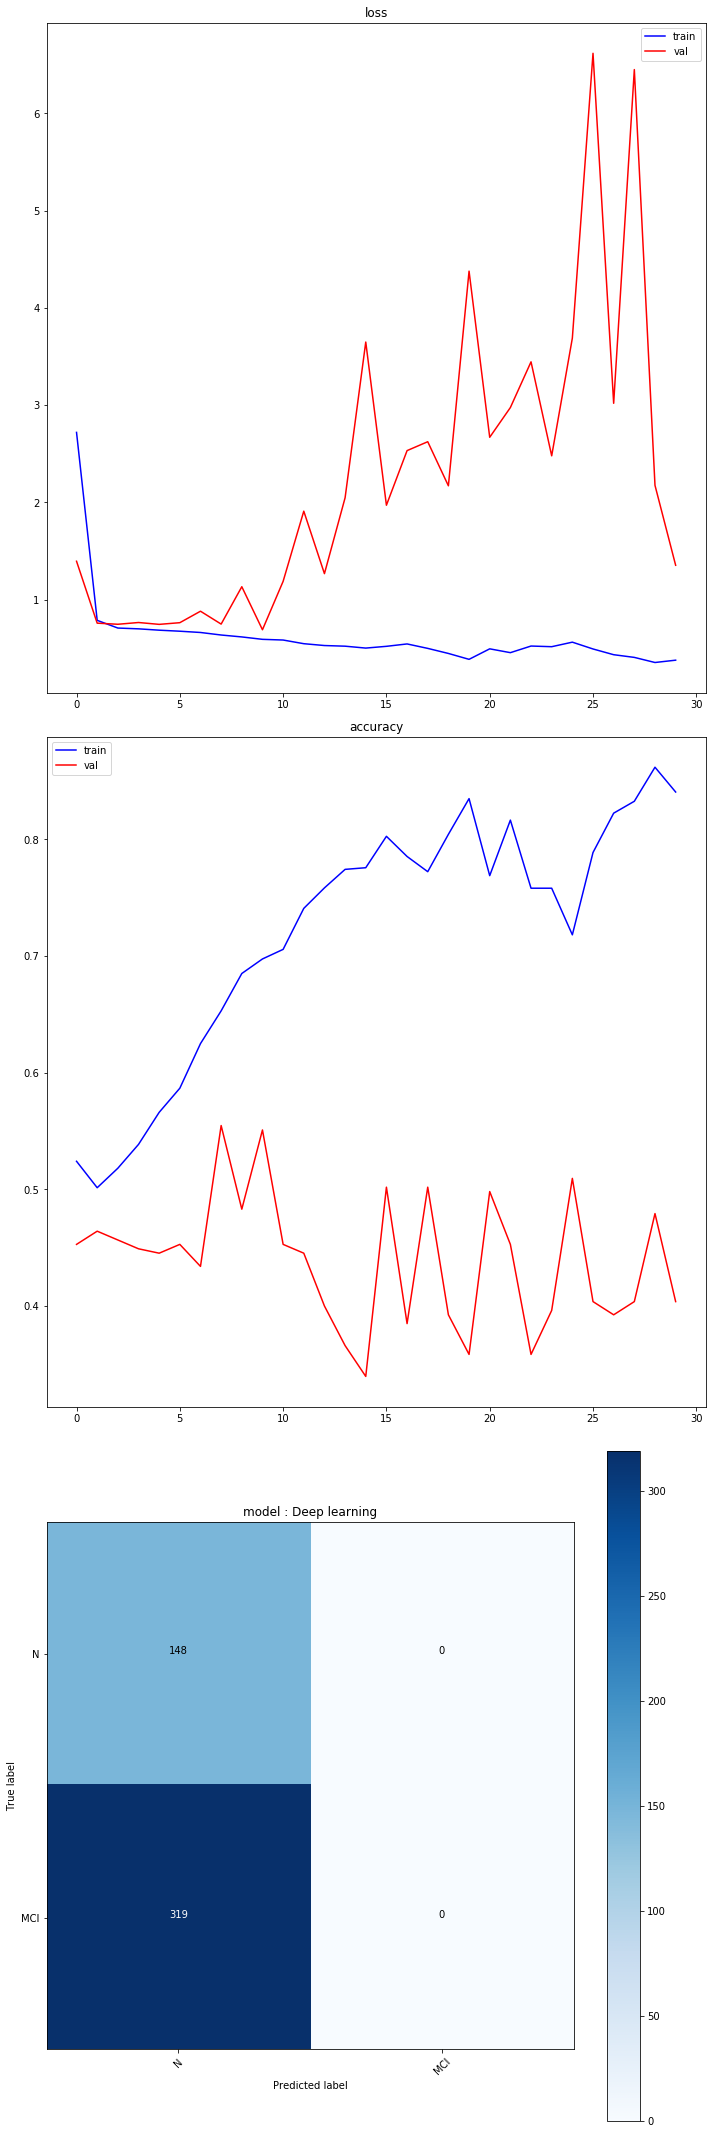

In [100]:
t = trying()